In [1]:
from pyHalo.pyhalo import pyHalo
import numpy as np
from time import time
from copy import deepcopy
import matplotlib.pyplot as plt

## To generate realizations with pyHalo you first have to specify a number of keyword arguments to specify mass definitions, lens/source redshift, etc.

In [2]:
zlens, zsource = 0.5, 1.5
rendering_volume = 'DOUBLE_CONE' # other option is CYLINDER
cone_opening_angle = 6. # the opening angle of the cone inside which halos are rendered, specified in arcseconds
# A reasonable choice would be opening_angle = 6 * R_ein, where R_ein is the Einstein radiuss of the lens in arcsec
kwargs_halo_mass_function = {'geometry_type': rendering_volume}

# properties of the realization
mass_definition = 'TNFW' # truncated NFW profile, other options are 
# 'NFW', 'SIDM_TNFW' (has a core), 'PT_MASS' (point mass), 'SIS', 'PJAFFE' (truncated SIS)

log_mlow = 6. # log(minimum halo mass)
log_mhigh = 10 # log(maximum halo mass)
power_law_index = -1.9 # logarithmic slope of the subhalo mass function (SHMF)
LOS_norm = 1. # rescales the line of sight halo mass function relative to Sheth-Tormen
sigma_sub = 0.02 # normalization of the SHMF (same parameterization as Gilman et al. 2020)
r_tidal = '0.25Rs' # subhalos are distributed in 3D following a cored NFW profile with a core radius r_tidal. 
# the scale radius of the host is computed from the host halo mass you specify 
log_m_host = 13.

# since we add halos to Universe we have to subtract what we add so that on 
# average the density of the Universe is rho_crit. This is accomplished by adding sheets of negative convergence;
# use these keywords to specify in what mass range to compute the correction. Since we are adding halos everywhere between
# 10^6 and 10^10 we'll keep these the same as log_mlow and log_mhigh
log_mass_sheet_min = 6
log_mass_sheet_max = 10

# now we can create an instance of pyhalo, this assumes a default cosmology specified in pyhalo.defaults
pyhalo = pyHalo(zlens, zsource, kwargs_halo_mass_function=kwargs_halo_mass_function)

# This will assume a default mass-concentration relation using the Diemer & Joyce (2019) model
t0 = time()
realization_kwargs = {'mass_func_type': 'POWER_LAW', 'log_mlow': log_mlow, 'log_mhigh': log_mhigh, 
                      'log_mass_sheet_min': log_mlow, 'log_mass_sheet_max': log_mhigh, 
                      'mdef_main': mass_definition,'mdef_los': mass_definition, 'sigma_sub': sigma_sub,
                      'cone_opening_angle': cone_opening_angle, 
                      'log_m_host': log_m_host, 'power_law_index': power_law_index, 'r_tidal': r_tidal,
                      'LOS_normalization': LOS_norm}

# for line of sight + subhalos
realization_type = 'composite_powerlaw'

# this creates a list of realizations of length nrealizations
realization = pyhalo.render(realization_type, realization_kwargs, nrealizations=1)[0]
tend = time()
Nhalos = len(realization.halos)
print('rendered '+str(Nhalos)+' halos in '+str(tend - t0)+' sec')

rendered 4115 halos in 0.5027790069580078 sec


## pyhalo is designed to be used with the software lenstronomy (https://github.com/sibirrer/lenstronomy)
## In one step, you can go from a pyhalo realization to an instance of LensModel

In [3]:
lens_model_list, lens_redshift_array, kwargs_halos, _ = realization.lensing_quantities()
# the last argument is only used for lens models with numerical deflection angles
# note that len(lens_model_list) != len(realization.halos) because the lens_model_list includes 
# the negative convergence sheets 

from lenstronomy.LensModel.lens_model import LensModel

# You should use the same astropy class created in pyhalo to do lensing computations
astropy_instance = pyhalo.astropy_cosmo
lens_model_halos_only = LensModel(lens_model_list, zlens, zsource, lens_redshift_array, cosmo=astropy_instance, multi_plane=True)

## You can then look at the multi-plane convergence from subhalos only...

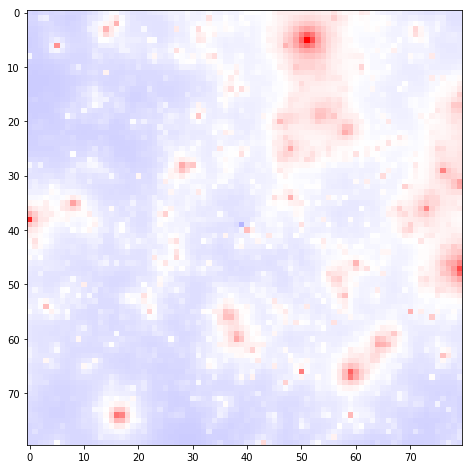

In [4]:
npix = 80 
_x = _y = np.linspace(-1.5, 1.5, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa_subs = lens_model_halos_only.kappa(xx.ravel(), yy.ravel(), kwargs_halos).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_subs, vmin=-0.1, vmax=0.1, cmap='bwr')

### ... and the nonlinear effects that arise when the deflection angles from subhalos couple to those of a massive deflector 

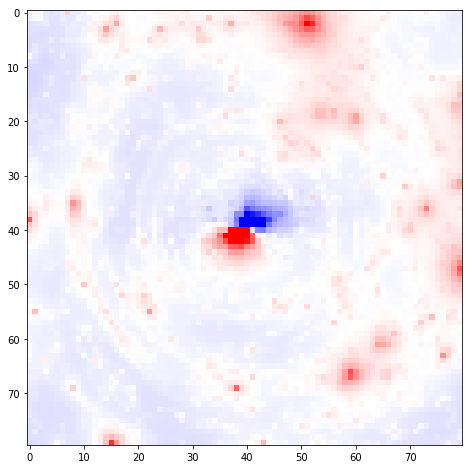

In [5]:
# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.04, 'gamma2': 0.09}]

lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_list_full = lens_model_list_macro + lens_model_list
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full = kwargs_macromodel + kwargs_halos

lens_model_full = LensModel(lens_model_list_full, zlens, zsource, lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True)
lens_model_macro = LensModel(lens_model_list_macro)

kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
kappa_subs_nonlinear = kappa_full - kappa_macro
plt.imshow(kappa_subs_nonlinear, vmin=-0.1, vmax=0.1, cmap='bwr')

# Warm dark matter

### You can change the dark matter model by specifying certain keyword arguments. For example, you can implement WDM models with the parameters "log_m_break", "break_scale", and "break_index". This introdues a turnover in halo mass function parameterized as

\begin{equation}
\frac{dN_{\rm{WDM}}}{dm} = \frac{dN_{\rm{CDM}}}{dm} \left(1 + \left(\frac{m_{\rm{hm}}}{m}\right)^{\alpha} \right)^{\beta}
\end{equation}

### where $\alpha$ corresponds to "break_scale", $\beta$ corresponds to "break_index", and the half-mode mass $m_{{hm}}$ corresponds to "log_m_break". 

### Halo concentrations are suppressed in WDM relative to the CDM prediction. The current CDM prediction for the mass-concentration relation is the Diemer-Joyce model mentioned above. Relative to CDM, the WDM halo concentrations are

\begin{equation}
\frac{c_{\rm{WDM}}}{c_{\rm{CDM}}} = \left(1+z\right)^{\beta \left(z\right)} \left( 1 + \gamma \frac{m_{\rm{hm}}}{m} \right)^{\delta} 
\end{equation}

### where $\gamma$ corresponds to the keyword argument "c_scale" and $\delta$ corresponds to the keyword argument "c_power". If these valuess are not specified, but log_m_break is specified, the code will assume default values of $\left(\gamma, \delta \right) = \left(60, -0.17 \right)$ (see Bose et al. 2016). The term that modifies the redshift evolution is given by $\beta\left(z\right) = 0.026 z - 0.04$. 

In [6]:
log_m_break = 7.5
break_index = -1.3
break_scale = 1.

realization_kwargs_wdm = deepcopy(realization_kwargs)
realization_kwargs_wdm['break_index'] = break_index
realization_kwargs_wdm['log_m_break'] = log_m_break
realization_kwargs_wdm['break_scale'] = break_scale

# this creates a list of realizations of length nrealizations
t0 = time()
realization_WDM = pyhalo.render(realization_type, realization_kwargs_wdm, nrealizations=1)[0]
tend = time()
Nhalos = len(realization_WDM.halos)
print('rendered '+str(Nhalos)+' halos in '+str(tend - t0)+' sec')

rendered 322 halos in 0.43592095375061035 sec


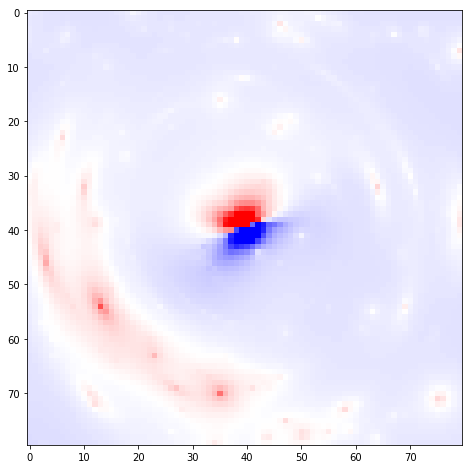

In [7]:
lens_model_list_WDM, lens_redshift_array_WDM, kwargs_halos_WDM, _ = realization_WDM.lensing_quantities()

lens_model_list_full_WDM = lens_model_list_macro + lens_model_list_WDM
lens_redshift_list_full_WDM = [zlens, zlens] + list(lens_redshift_array_WDM)
kwargs_lens_full_WDM = kwargs_macromodel + kwargs_halos_WDM

lens_model_full_WDM = LensModel(lens_model_list_full_WDM, zlens, zsource, lens_redshift_list_full_WDM, 
                                cosmo=astropy_instance, multi_plane=True)

kappa_full_WDM = lens_model_full_WDM.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full_WDM).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_full_WDM - kappa_macro, vmin=-0.1, vmax=0.1, cmap='bwr')

## Custom CDM mass-concentration relations

### You can implement a custom mass-concentration relation parameterized as a power law in peak height $\nu$ with three free parameters: $c_0$, $\beta$, and $\zeta$ (see Gilman et al. 2020 for the details). Briefly, these parameters are the concentration of 10^8 halos at z=0, the logarithmic slope of the mass-concentration relation around 10^8, and a modification to the redshift evolution, respectively. 

### Note: custom CDM mass-concentration relations don't currently work with warm dark matter models

### You specify the keyword arguments as follows: 

In [8]:
c0 = 40 # CDM prediction is ~17
beta = 0.8 # CDM prediction is ~0.8
zeta = -0.25 # CDM prediction is ~ -0.25

realization_kwargs_customMC = deepcopy(realization_kwargs)
realization_kwargs_customMC['mc_model'] = {'custom': True, 'c0': c0, 'beta': beta, 'zeta': zeta}
t0 = time()
realization_customMC = pyhalo.render(realization_type, realization_kwargs_customMC, nrealizations=1)[0]
tend = time()
Nhalos = len(realization_customMC.halos)
print('rendered '+str(Nhalos)+' halos in '+str(tend - t0)+' sec')

rendered 4296 halos in 0.4620239734649658 sec


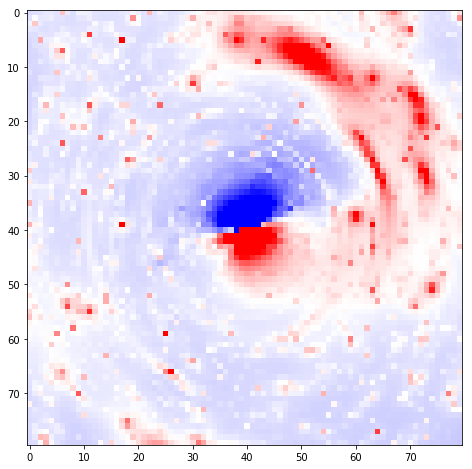

In [9]:
lens_model_list_customMC, lens_redshift_array_customMC, kwargs_halos_customMC, _ = realization_customMC.lensing_quantities()

lens_model_list_full_customMC = lens_model_list_macro + lens_model_list_customMC
lens_redshift_list_full_customMC = [zlens, zlens] + list(lens_redshift_array_customMC)
kwargs_lens_full_customMC = kwargs_macromodel + kwargs_halos_customMC

lens_model_full_customMC = LensModel(lens_model_list_full_customMC, zlens, zsource, lens_redshift_list_full_customMC, 
                                cosmo=astropy_instance, multi_plane=True)

kappa_full_customMC = lens_model_full_customMC.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full_customMC).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_full_customMC - kappa_macro, vmin=-0.1, vmax=0.1, cmap='bwr')